In [35]:
# Imports
import math
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, Point
import matplotlib.pyplot as plt
from pyproj import Transformer, Geod

In [36]:
# Load and clean flow data
raw_flows_df = pd.read_excel('../../data/europe/data_europe.xlsx')

# Rename destination column and reshape
long_flows_df = (
    raw_flows_df
    .rename(columns={'University ↓ / Student →': 'destination'})
    .melt(id_vars='destination', var_name='origin', value_name='value')
    .dropna(subset=['value'])
)

# Strip whitespace and remove self-references
long_flows_df['origin'] = long_flows_df['origin'].str.strip()
long_flows_df['destination'] = long_flows_df['destination'].str.strip()
long_flows_df = long_flows_df[long_flows_df['origin'] != long_flows_df['destination']]

# Select relevant columns only
flows_df = long_flows_df[['origin', 'destination', 'value']]

In [37]:
# Load European regions
regions_gdf = gpd.read_file('../../data/europe/CNTR_RG_01M_2024_3035.gpkg')
regions_gdf = regions_gdf[['NAME_ENGL', 'geometry']]

# Calculate initial representative centroids
regions_gdf['centroid'] = regions_gdf.representative_point()

# Define transformer from WGS84 to layer CRS
wgs_to_crs = Transformer.from_crs("EPSG:4326", regions_gdf.crs, always_xy=True)

# Define manual centroid overrides (lon, lat) → transform to target CRS
manual_coords = {
    'Türkiye': (31.5, 39.5),
    'Greece': (22.8, 37.5),
    'Germany': (10.0, 50.5),#10.0, 50.0
    'Czechia': (15.0, 49.8),
    'Slovakia': (19.8, 48.8),
    'Latvia': (25.5, 56.8),
    'Sweden': (16.5, 63.5),
    'Austria': (14.8, 47.6),
}

# Convert to Points in target CRS
manual_centroids = {
    country: Point(*wgs_to_crs.transform(lon, lat))
    for country, (lon, lat) in manual_coords.items()
}

# Override centroids where needed
regions_gdf['centroid'] = regions_gdf.apply(
    lambda row: manual_centroids.get(row['NAME_ENGL'], row['centroid']),
    axis=1
)

In [38]:
# Prepare centroids for merging
centroids_gdf = regions_gdf.rename(columns={'NAME_ENGL': 'region'})[['region', 'centroid']]
centroids_gdf = centroids_gdf.set_geometry('centroid')
centroids_gdf = centroids_gdf.set_crs(epsg=3035)
centroids_wgs = centroids_gdf.to_crs(epsg=4326)
print(centroids_wgs.loc[centroids_wgs['region'] == 'Austria', 'centroid'])

12    POINT (14.8 47.6)
Name: centroid, dtype: geometry


In [39]:
# Define orthodromic line function
geod = Geod(ellps="WGS84")

def ortodrome(start, end, n_points=100):
    lon1, lat1 = start.x, start.y
    lon2, lat2 = end.x, end.y
    intermediate_points = geod.npts(lon1, lat1, lon2, lat2, n_points)
    coords = [(lon1, lat1)] + intermediate_points + [(lon2, lat2)]
    return LineString(coords)

In [40]:
# Merge flows with centroid coordinates
flows_merged = (
    flows_df
    .merge(centroids_wgs, left_on='origin', right_on='region', how='left')
    .rename(columns={'centroid': 'centroid_origin'})
    .drop(columns='region')
    .merge(centroids_wgs, left_on='destination', right_on='region', how='left')
    .rename(columns={'centroid': 'centroid_destination'})
    .drop(columns='region')
)

flows_merged['geometry'] = flows_merged.apply(
    lambda r: ortodrome(r.centroid_origin, r.centroid_destination)
    if pd.notnull(r.centroid_origin) and pd.notnull(r.centroid_destination)
    else LineString(),
    axis=1
)

flows_gdf = gpd.GeoDataFrame(
    flows_merged[['origin', 'destination', 'value', 'geometry']],
    geometry='geometry',
    crs="EPSG:4326"
).to_crs(epsg=3035)

In [41]:
# Compute total flow per undirected pair
flows_gdf['pair'] = flows_gdf.apply(
    lambda r: tuple(sorted([r['origin'], r['destination']])), axis=1)
flows_gdf['value_total'] = flows_gdf.groupby('pair')['value'].transform('sum')
flows_gdf = flows_gdf.drop(columns='pair')

In [42]:
# Compute percentage of flow (pct)
flows_gdf['pct'] = (flows_gdf['value'] / flows_gdf['value_total'] * 100).round(2)
flows_gdf['pct'] = pd.to_numeric(flows_gdf['pct'], errors='coerce')

In [43]:
# Add orientation flag based on direction
def determine_orientation(row):
    line = row.geometry
    if isinstance(line, LineString):
        start = line.coords[0]
        end = line.coords[-1]
        return 1 if end[1] > start[1] else -1
    return 0

flows_gdf['orientation'] = flows_gdf.apply(determine_orientation, axis=1)

In [44]:
# Function to calculate angle in degrees (0 = east, 90 = north)
def calculate_orientation_degrees(row):
    line = row.geometry
    if isinstance(line, LineString):
        start = line.coords[0]
        end = line.coords[-1]
        dx = end[0] - start[0]
        dy = end[1] - start[1]
        angle_rad = math.atan2(dy, dx)
        angle_deg = math.degrees(angle_rad)
        return angle_deg % 360  # normalize to 0–360
    return None

# Apply to GeoDataFrame
flows_gdf['rotation'] = flows_gdf.apply(calculate_orientation_degrees, axis=1)

In [45]:
# Trim line by pct

def trim_line_by_pct(row):
    line = row.geometry
    pct = row.pct
    if not isinstance(line, LineString) or pct is None:
        return line
    if pct >= 100:
        return line
    target_length = line.length * (pct / 100)
    trimmed_coords = []
    current_length = 0
    for i in range(len(line.coords) - 1):
        start = line.coords[i]
        end = line.coords[i + 1]
        segment = LineString([start, end])
        seg_length = segment.length
        if current_length + seg_length < target_length:
            trimmed_coords.append(start)
            current_length += seg_length
        else:
            remaining = target_length - current_length
            if remaining > 0:
                point = segment.interpolate(remaining)
                if point is not None:
                    trimmed_coords.append(start)
                    trimmed_coords.append((point.x, point.y))
            break
    if len(trimmed_coords) < 2:
        endpoint = line.interpolate(target_length)
        if endpoint is not None:
            return LineString([line.coords[0], (endpoint.x, endpoint.y)])
        else:
            return LineString([line.coords[0], line.coords[0]])
    return LineString(trimmed_coords)

flows_gdf['geometry'] = flows_gdf.apply(trim_line_by_pct, axis=1)

In [46]:
# Export trimmed lines
flows_gdf.to_file("../../data/europe/europe_flows.gpkg", driver="GPKG", layer="trimmed_lines")

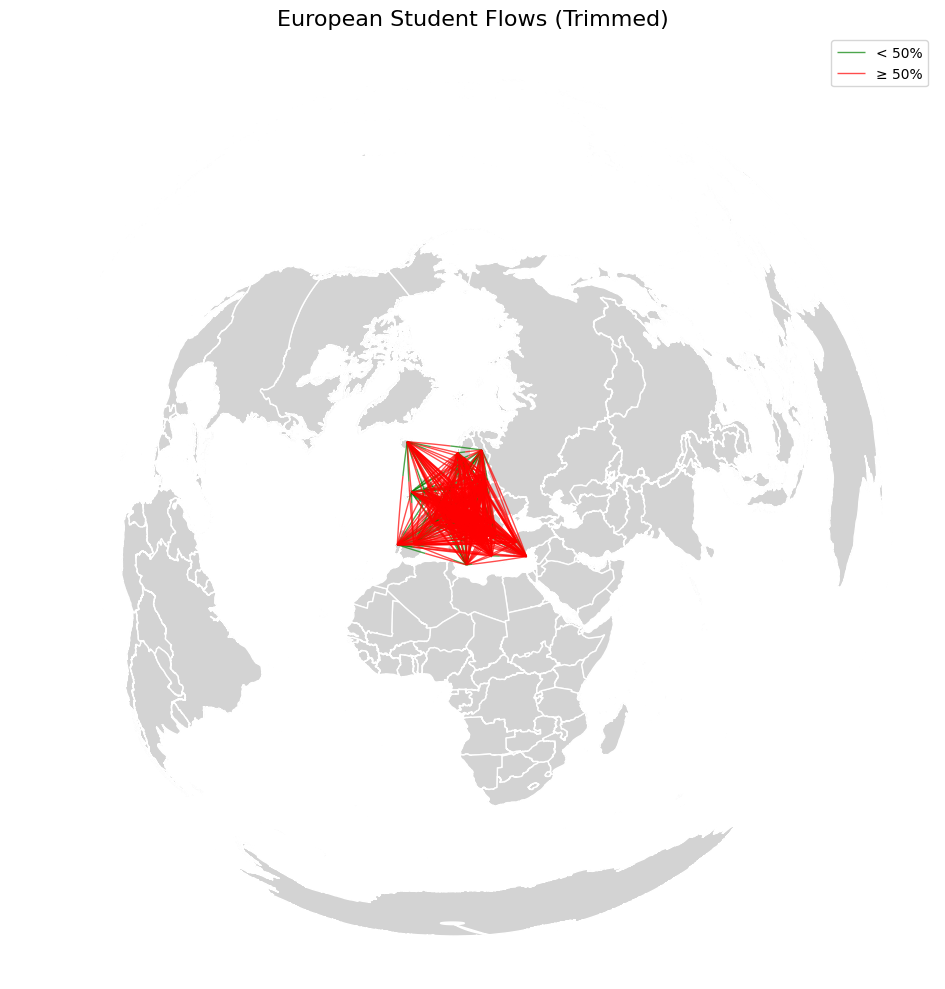

In [47]:
# Visualization
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot background map
regions_gdf.plot(ax=ax, color='lightgrey', edgecolor='white')

# Plot trimmed lines by pct
flows_gdf[flows_gdf['pct'] < 50].plot(
    ax=ax, color='green', linewidth=1, alpha=0.7, label='< 50%'
)
flows_gdf[flows_gdf['pct'] >= 50].plot(
    ax=ax, color='red', linewidth=1, alpha=0.7, label='≥ 50%'
)

ax.set_title("European Student Flows (Trimmed)", fontsize=16)
ax.axis('off')
ax.legend()
plt.tight_layout()
plt.show()